In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
from torch import nn
import torch
import time
import unet
from IPython.utils import io


import swyft
import pylab as plt
import scipy.stats.distributions as dist
from tqdm import tqdm

torch.set_float32_matmul_precision('medium')
DEVICE = "cuda"

/home/cweniger/.pyenv/versions/3.10.11/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import logging

### Generative model

In [12]:
class SimulatorBlob(swyft.Simulator):
    def __init__(self, bounds = None, Npix = 64, sigma = 0.1):
        super().__init__()
        self.transform_samples = swyft.to_numpy32
        self.theta_sampler = swyft.RectBoundSampler([dist.uniform(3.75, 0.5)])
        self.bounds = bounds
        self.Npix = Npix
        self.sigma = sigma
        self.powersampler = swyft.utils.PowerSpectrumSampler(Npix)
        self.sigma = torch.ones(Npix, Npix)*0.1
#        self.sigma[:,:Npix//2] *= 1000

    def get_pk_fn(self, theta):
        return lambda k: 1e6*3*(k/0.5+1)**-theta[0]
        
    def sample_delta(self, pk_fn, use_bounds = True):
        if self.bounds is not None and use_bounds:
            i = np.random.randint(len(self.bounds))
            return torch.tensor(self.bounds[i])
        else:
#            return self.powersampler.sample(lambda k: 1e6*3*(k/0.5)**-theta[0])
            return self.powersampler.sample(pk_fn)

    def psf(self, rho):
        return rho
            
    def build(self, graph):
        theta = graph.node("theta", self.theta_sampler)
        pk_fn = graph.node("pk_fn", self.get_pk_fn, theta)
        delta = graph.node("delta", self.sample_delta, pk_fn)
        delta_unbound = graph.node("delta_unbound", lambda pk_fn: self.sample_delta(pk_fn, use_bounds = False), pk_fn)
        rho = graph.node("rho", lambda delta: torch.exp(delta/5), delta)
        x = graph.node("x", lambda rho: self.psf(rho) + torch.randn(self.Npix, self.Npix)*self.sigma, rho)
#        z = graph.node("test", lambda: lambda x: x)

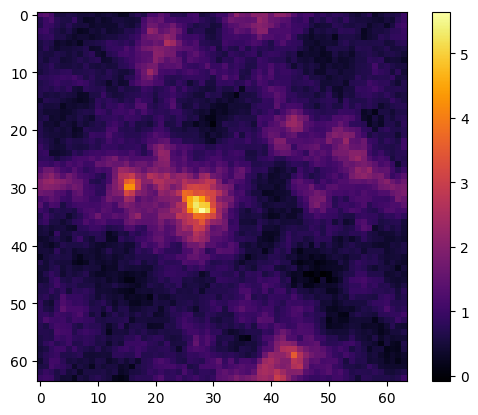

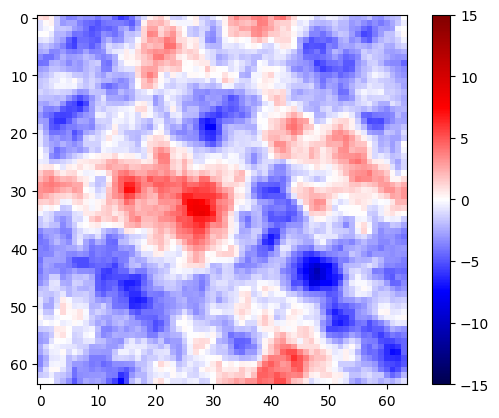

In [13]:
NPIX = 64
sim = SimulatorBlob(Npix = NPIX)
sample0 = sim.sample(conditions = dict(theta = np.array([4.])))
del sample0['pk_fn']
plt.imshow(sample0['x'], cmap = 'inferno')
plt.colorbar()
plt.show()
plt.imshow(sample0['delta'], vmin = -15, vmax = 15, cmap = 'seismic')
plt.colorbar()
plt.show()

### Inference network

In [14]:
class Network(swyft.SwyftModule):
    def __init__(self, lr=1e-3, N = 1024):
        super().__init__()
        self.optimizer_init = swyft.AdamOptimizerInit(lr=1e-4, lrs_factor=0.1, lrs_patience=3)
        self.N = N
        L = lambda x: x*0
        self.Phi = lambda x: x
        self.PhiT = lambda x: x
        self.lre = swyft.LogRatioEstimator_Gaussian_Autoregressive_X_module_based(
            self.N**2, "mu", Phi = self.Phi, PhiT = self.PhiT, L = L, minstd = 1e-5, momentum=0.02)
        self.unet = unet.UNet(1, 1, s = 4)
        self.cnn = torch.nn.Sequential(
            torch.nn.LazyConv2d(8, 3), torch.nn.LazyConv2d(8, 3), torch.nn.ReLU(), torch.nn.MaxPool2d(2), torch.nn.LazyBatchNorm2d(),
            torch.nn.LazyConv2d(16, 3), torch.nn.LazyConv2d(16, 3), torch.nn.ReLU(), torch.nn.MaxPool2d(2), torch.nn.LazyBatchNorm2d(),
            torch.nn.LazyConv2d(32, 3), torch.nn.LazyConv2d(32, 3), torch.nn.ReLU(), torch.nn.MaxPool2d(2), torch.nn.LazyBatchNorm2d(),
            #torch.nn.LazyConv2d(64, 3), torch.nn.LazyConv2d(64, 3), torch.nn.ReLU(), torch.nn.MaxPool2d(2), torch.nn.LazyBatchNorm2d(),
        )
        self.mlp = torch.nn.Sequential(
            torch.nn.LazyLinear(256), torch.nn.ReLU(), torch.nn.LazyBatchNorm1d(),
            torch.nn.LazyLinear(128), torch.nn.ReLU(), torch.nn.LazyBatchNorm1d(),
            torch.nn.LazyLinear(64), torch.nn.ReLU(), torch.nn.LazyBatchNorm1d(),
            torch.nn.LazyLinear(4)
        )
        self.cnn3 = torch.nn.Sequential(
            torch.nn.LazyConv2d(8, 3), torch.nn.LazyConv2d(8, 3), torch.nn.ReLU(), torch.nn.MaxPool2d(2), torch.nn.LazyBatchNorm2d(),
            torch.nn.LazyConv2d(16, 3), torch.nn.LazyConv2d(16, 3), torch.nn.ReLU(), torch.nn.MaxPool2d(2), torch.nn.LazyBatchNorm2d(),
            torch.nn.LazyConv2d(32, 3), torch.nn.LazyConv2d(32, 3), torch.nn.ReLU(), torch.nn.MaxPool2d(2), torch.nn.LazyBatchNorm2d(),
            #torch.nn.LazyConv2d(64, 3), torch.nn.LazyConv2d(64, 3), torch.nn.ReLU(), torch.nn.MaxPool2d(2), torch.nn.LazyBatchNorm2d(),
        )
        self.mlp3 = torch.nn.Sequential(
            torch.nn.LazyLinear(256), torch.nn.ReLU(), torch.nn.LazyBatchNorm1d(),
            torch.nn.LazyLinear(128), torch.nn.ReLU(), torch.nn.LazyBatchNorm1d(),
            torch.nn.LazyLinear(64), torch.nn.ReLU(), torch.nn.LazyBatchNorm1d(),
            torch.nn.LazyLinear(4)
        )

        self.lre2 = swyft.LogRatioEstimator_1dim(4, 1, 'theta:delta')
        self.lre3 = swyft.LogRatioEstimator_1dim(4, 1, 'theta')

        self.norm2b = torch.nn.LazyBatchNorm1d()
        self.norm2a = torch.nn.LazyBatchNorm2d()
        self.norm1 = torch.nn.LazyBatchNorm2d()
        self.norm3 = torch.nn.LazyBatchNorm2d()
    
    def embed(self, x):
        x = self.norm1(x.unsqueeze(1)).squeeze(1)
        x = self.unet(x.unsqueeze(1)).squeeze(1) + x
        x = x.view(-1, self.N**2)
        return x

    def embed2a(self, delta):
        f = self.norm2a(delta)
        f = self.cnn(f.unsqueeze(1)).flatten(start_dim = 1)
        f = self.mlp(f)
        return f

    def embed2b(self, delta):
        f = swyft.utils.ps.get_pk(delta)
        f = self.norm2b(f)
        f = self.mlp(f)
        return f

    def embed3(self, x):
        x = self.norm3(x.unsqueeze(1)).squeeze(1)
        f = self.cnn3(x.unsqueeze(1)).flatten(start_dim = 1)
        f = self.mlp3(f)
        return f

    def forward(self, A, B):
        N = self.N
        try:
            rhoA = self.embed(A['x'])
            rhoB = self.embed(B['x'])
            deltaB = B['delta'].view(-1, N**2)
            result1 = self.lre(rhoA, rhoB, deltaB)
        except KeyError:
            result1 = None

        try:
            f2 = self.embed2b(A['delta_unbound'])
            result2 = self.lre2(f2, B['theta'])
        except KeyError:
            result2 = None

        try:
            f3 = self.embed3(A['x'])
            result3 = self.lre3(f3, B['theta'])
        except KeyError:
            result3 = None
        
        return result1, result2, result3

### Inference

In [19]:
def round(bounds = None, max_epochs = 5, n_sims = 1000, gamma = 0.1, n_draws = 200, slope =4.):
    sim = SimulatorBlob(Npix = NPIX, bounds = bounds)
    samples = sim.sample(n_sims, exclude = ['pk_fn'])
    #net.cpu(); net.float()
    dm = swyft.SwyftDataModule(samples, fractions = [0.9, 0.1, 0.0], batch_size = 64)
    net = Network(N = NPIX)
    trainer = swyft.SwyftTrainer(accelerator = "gpu", devices = [0], max_epochs = max_epochs, precision = 32, )
    logging.getLogger("lightning.pytorch.accelerators.cuda").setLevel(logging.ERROR)
    trainer.fit(net, dm)
    
    GAMMA = gamma # 0.1 # 0.0001
    
    x = sample0['x']
    d = sample0['delta']
    y = net.cuda().double().embed(torch.tensor(x).cuda().double().unsqueeze(0))[0]
    draws = []
    x0s = []
    for _ in tqdm(range(n_draws)):
        pk = SimulatorBlob(Npix = NPIX).sample()['pk_fn']
        prior = sim.powersampler.get_prior_Q_factors(pk)
        prior = (prior[0], prior[1].cuda(), prior[2])
        x0 = net.lre.get_MAP(y, prior, gamma = GAMMA)
        x0s.append(x0)
        draw = net.lre.get_noise_samples_GEDA(1, prior, steps = 300, reset = True, gamma = GAMMA)[0]
        draws.append(draw)
    draws = torch.stack(draws)
    x0s = torch.stack(x0s)
    
    bounds = [(x0s[i].view(NPIX, NPIX).cpu().detach() + draws[i].view(NPIX, NPIX).cpu()).numpy() for i in range(len(draws))]
    bounds = np.array(bounds)

    net.float()
    
    v = 15
    plt.figure(figsize = (15, 5))
    for i in range(4):
        plt.subplot(2, 4, i+1)
        if i == 0:
            plt.imshow(sample0['delta'], cmap = 'seismic', vmin = -v, vmax = v)
        else:
            plt.imshow(bounds[i], vmin = -v, vmax = v, cmap = 'seismic')
        plt.colorbar()    
    #res = [(x0.view(NPIX, NPIX).cpu().detach()*0 + draws[i].view(NPIX, NPIX).cpu()).numpy() for i in range(len(draws))]
    print(x.min(), x.max(), bounds[0].min(), bounds[0].max())
    res = [d - bounds[i] for i in range(len(draws))]
    for i in range(4):
        plt.subplot(2, 4, i+1+4)
        plt.imshow(res[i], vmin = -v, vmax = v, cmap = 'seismic')
        plt.colorbar()
    plt.show()

    x = sample0['delta'].flatten()
    y = bounds.reshape(-1, NPIX**2)
    ym = y.mean(axis=0)
    ys = y.std(axis=0)
    plt.scatter(x, ym)
    plt.scatter(x, x)
    plt.show()

    diff = ((y-x)/ys).flatten()
    plt.hist(diff, bins = 100)
    plt.show()
    p = np.percentile(diff, [2.5, 16, 50, 84, 97.5])
    print("Residual percentiles:", p)

    pks = swyft.utils.get_pk(torch.tensor(bounds))
    clean_sims = SimulatorBlob().sample(100)['delta']
    pks2 = swyft.utils.get_pk(torch.tensor(clean_sims))
    pks3 = swyft.utils.get_pk(torch.tensor(sample0['delta']))
    plt.plot([], '0.5', alpha = 0.5, label = "Unconstrained")
    plt.plot([], 'r', alpha = 0.5, label = "Constrained")
    plt.semilogy(pks2.T, '0.5', alpha = 0.5);
    plt.semilogy(pks.T, 'r', alpha = 0.5);
    plt.semilogy(pks3.T, 'y', label = "Truth");
    plt.legend()
    plt.show()

    prior_draws = sim.sample(1000, targets = ["theta"], exclude = ['pk_fn'])
    results = trainer.infer(net, sample0, prior_draws)

    swyft.plot_1d(results, 'theta[0]', smooth = 1)
    plt.show()
    swyft.plot_1d(results, 'theta:delta[0]', smooth = 1)
    plt.title("Constraint from ground truth delta")
    plt.show()

    prior_draws = sim.sample(10000, targets = ["theta"], exclude = ['pk_fn'])
    s = swyft.Samples(dict(delta_unbound = torch.tensor(bounds).float()))
    results = trainer.infer(net, s.get_dataloader(batch_size = 1, repeat = 1), prior_draws.get_dataloader(batch_size = 10000))

    swyft.plot_1d(results, 'theta:delta[0]', smooth = 1)
    plt.title("Constraint from ground bounded delta")
    plt.show()

    return bounds, trainer, net, sim

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:02<00:00, 1281.72it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name   | Type                                                     | Params
-------------------------------------------------------------------------------------
0  | lre    | LogRatioEstimator_Gaussian_Autoregressive_X_module_based | 0     
1  | unet   | UNet                                                     | 1.9 M 
2  | cnn    | Sequential                                               | 0     
3  | mlp    | Sequential                                               | 0     
4  | cnn3   | Sequential                                               | 0     
5  | mlp3   | Sequential                                  

Epoch 0:  90%|███████████████████████████████████████████████████████████████████████████████████████████████▊           | 43/48 [00:03<00:00, 11.52it/s, loss=-1.33e+03, v_num=214]
Validation: 0it [00:00, ?it/s]
Epoch 1:  90%|██████████████████████████████████████████████████████████████████████████████▊         | 43/48 [00:03<00:00, 11.86it/s, loss=-4.74e+03, v_num=214, val_loss=-3.32e+3]
Validation: 0it [00:00, ?it/s]
Epoch 2:  90%|██████████████████████████████████████████████████████████████████████████████▊         | 43/48 [00:03<00:00, 11.02it/s, loss=-5.68e+03, v_num=214, val_loss=-5.26e+3]
Validation: 0it [00:00, ?it/s]
Epoch 3:  90%|██████████████████████████████████████████████████████████████████████████████▊         | 43/48 [00:03<00:00, 11.31it/s, loss=-6.11e+03, v_num=214, val_loss=-5.98e+3]
Validation: 0it [00:00, ?it/s]
Epoch 4:  90%|██████████████████████████████████████████████████████████████████████████████▊         | 43/48 [00:03<00:00, 11.98it/s, loss=-6.34e+03, v

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|███████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:04<00:00, 11.21it/s, loss=-6.65e+03, v_num=214, val_loss=-6.88e+3]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  7.65it/s]


-0.085892886 5.6417294 -14.89189467112442 10.8861151178714


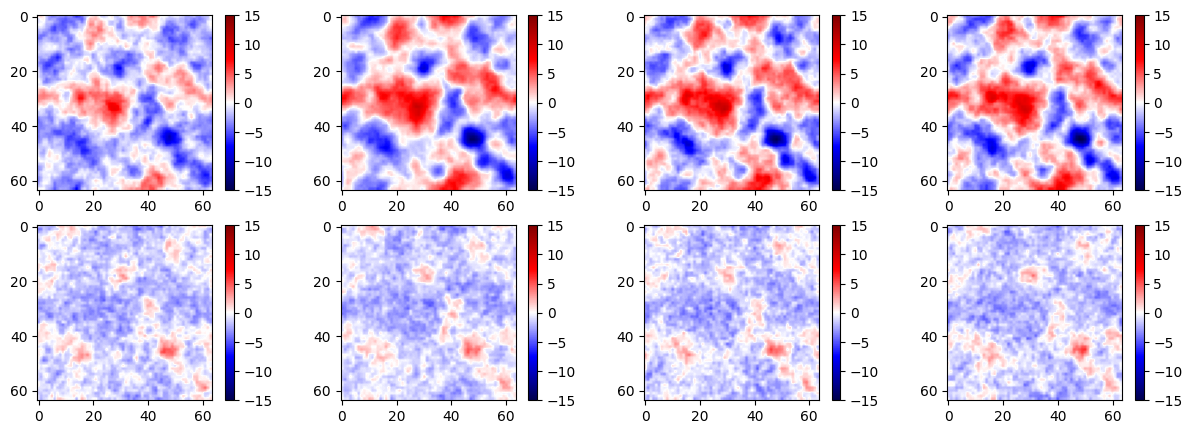

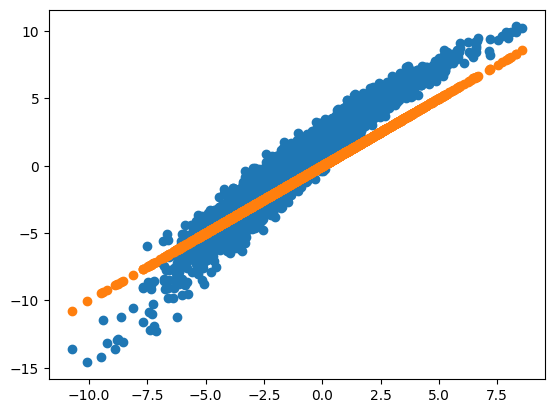

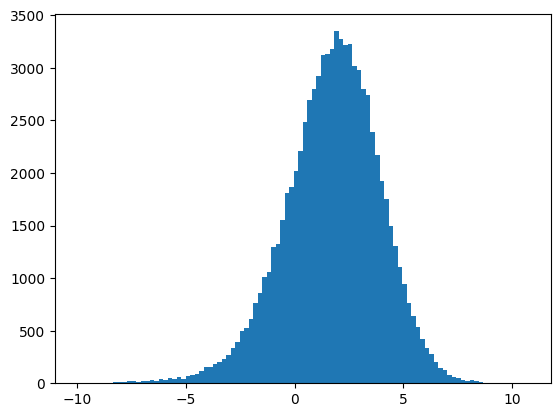

Residual percentiles: [-2.91104827 -0.34637885  1.8590847   3.82277384  5.67426325]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1354.85it/s]


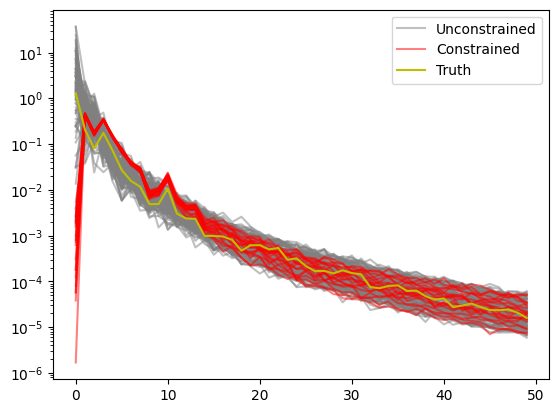

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 8984.07it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 49.39it/s]


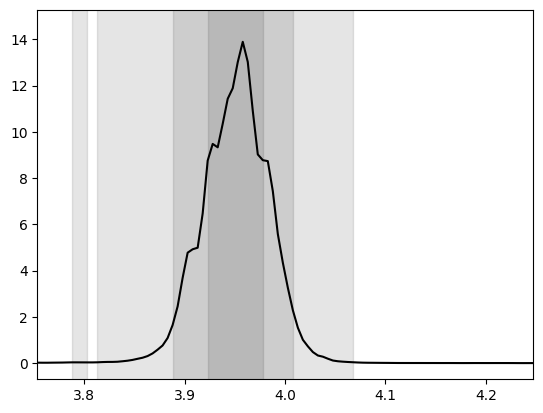

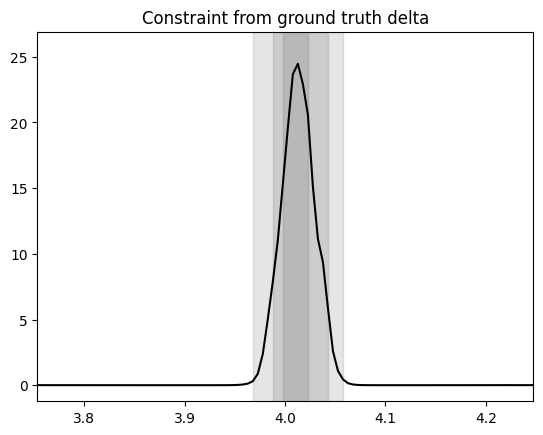

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 10647.81it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 21.16it/s]


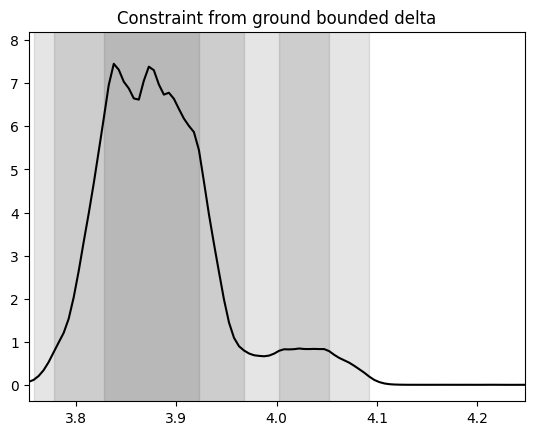

In [21]:
bounds = None
bounds, trainer, net, sim = round(bounds = bounds, max_epochs = 30, n_draws = 20, gamma = 1e-1, n_sims = 3000)